## Read d3plot from LS-DYNA using lasso-python

In [1]:
from read_d3plot import *

path_to_d3plot = r'C:\Users\kylin\OneDrive - Curtin\research\civil_engineering\data\FGN\C30_120_6_0.4\d3plot'
d3plot = D3plot(path_to_d3plot)

In [2]:
def extract_trajectory_type_strain(d3plot):
    """Read particle (element) trajectory of coordinates.
    
    Input: the d3plot data
    Output: particle_trajectories of shape [ntimesteps, nparticles, 3]
    """
    
    ## node_displacement is actually node coords in all steps, shape [nstep, nnodes, 3]
    node_trajectories = d3plot.arrays["node_displacement"]
    ## Each solid element (cubic) is defined by 8 nodes
    element_solid_node_indexes = d3plot.arrays["element_solid_node_indexes"]
    ## each beam involves 2 nodes, but the array shows 5 with 3rd being the same as 2nd
    ## and 4th, 5th looks unrelated
    ## Using LS-PrePost outputs 3 nodes per beam, with 3rd also being the same as 2nd
    ## Therefore, only the first 2 nodes are used
    element_beam_node_indexes = d3plot.arrays["element_beam_node_indexes"][:, :2]


    # Extract SPH particle trajectoriesy, each particle is a node and is numbered after
    # all solid element nodes. Do not need to worry about beam element nodes, as they are
    # shared with solid nodes. So we just need to eliminate all solid nodes from all nodes
    # to get SPH particles(nodes).
    
    # Convert the solid node indexes to a set for quick look-up
    sph_node_indexes = d3plot.arrays["sph_node_indexes"]
    SPH_trajectories = node_trajectories[:, sph_node_indexes, :]

    element_beam_node_indexes = np.unique(element_beam_node_indexes)
    
    element_beam_trajectories = node_trajectories[:, element_beam_node_indexes, :]

    particle_trajectories = np.concatenate((SPH_trajectories, element_beam_trajectories), axis=1)

    # Derive particle types, 0 concrete, 1 rebar, 2 boundary
    # boundary is always 150 mm on the two ends of y-axis
    SPH_types = np.zeros(SPH_trajectories.shape[1])
    beam_types = np.ones(element_beam_trajectories.shape[1])
    particle_type = np.concatenate((SPH_types, beam_types), axis=0)
    LEFT_BOUNDARY = -855    # particle_trajectories[0, :, 1].min() + 150, this not aligned with the data from txt
    RIGHT_BOUNDARY = 855    # particle_trajectories[0, :, 1].max() - 150
    mask = (particle_trajectories[0, :, 1] >= RIGHT_BOUNDARY) | (particle_trajectories[0, :, 1] <= LEFT_BOUNDARY)
    particle_type[mask] = 2
    
    # Strain
    solid_eps = d3plot.arrays["element_solid_effective_plastic_strain"][:, :, 0]
    beam_eps = np.zeros((solid_eps.shape[0], element_beam_trajectories.shape[1]))
    particle_strains = np.concatenate((solid_eps, beam_eps), axis=1)
    
    return particle_trajectories, particle_type, particle_strains

In [3]:
particle_trajectories, particle_type, particle_strains = extract_trajectory_type_strain(d3plot)

print(particle_trajectories.shape)
print(particle_strains.shape)
print(particle_type.shape)

(102, 246248, 3)
(102, 246248)
(246248,)


In [4]:
import numpy as np


def enforce_eps_non_decreasing(particle_strains):
    # Compute the differences between adjacent time steps
    strains_diff = np.diff(particle_strains, axis=0)

    # Set any negative differences to zero
    strains_diff[strains_diff < 0] = 0

    # Reconstruct the corrected strains using cumulative sum,
    # starting with the initial strain values
    corrected_strains = np.concatenate((particle_strains[:1, :], strains_diff), axis=0).cumsum(axis=0)
    return corrected_strains

## Test data

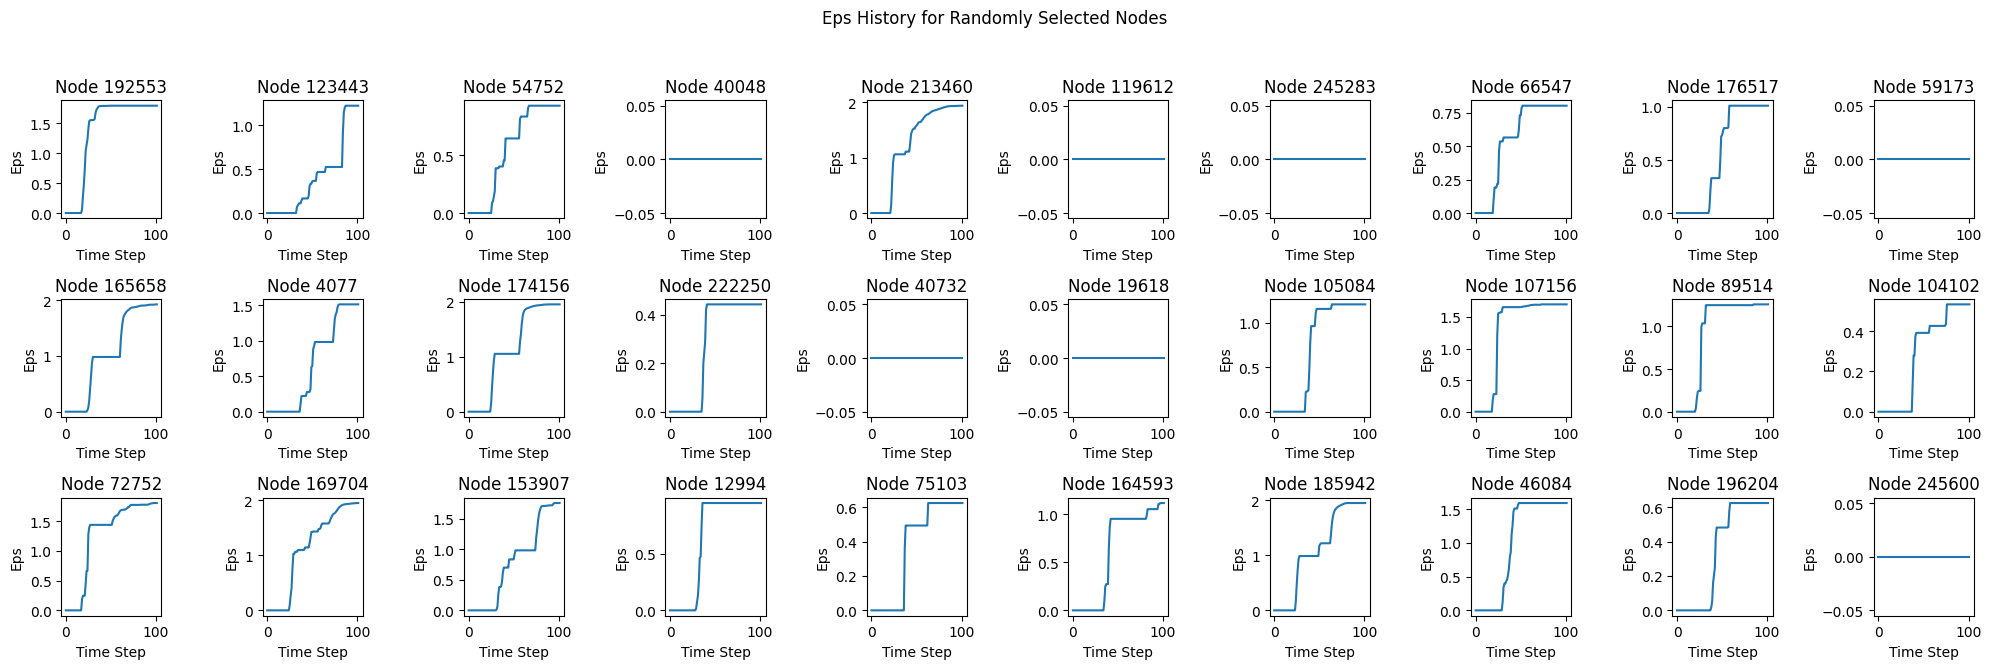

In [6]:
import numpy as np
import matplotlib.pyplot as plt

corrected_strains = enforce_eps_non_decreasing(particle_strains)
data = corrected_strains
nstep = data.shape[0]
nnode = data.shape[1]

# Randomly pick 20 nodes
random_nodes = np.random.choice(particle_strains.shape[1], 30, replace=False)

# Initialize the plot with subplots in 2 or 3 rows
nrows = 3  # You can change this to 2 if you prefer
ncols = int(np.ceil(30 / nrows))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 7))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Plot the eps history for the selected nodes
for i, node in enumerate(random_nodes):
    ax = axes[i]
    ax.plot(data[:, node])
    ax.set_title(f'Node {node}')
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Eps')

# Remove any unused subplots
for i in range(len(random_nodes), nrows * ncols):
    fig.delaxes(axes[i])

# Add a main title
plt.suptitle('Eps History for Randomly Selected Nodes')

# Show the plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()